# Training
### A Very simple CNN model to detect whether fabric in a solid color is jeans or not

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

### Preprocess data for model:

In [2]:
img_dim = (64, 64) 

In [3]:
def load_and_preprocess_images(folder_path):
    images = []
    labels = []

    for filename in os.listdir(folder_path):
        if filename.endswith('.jpg'):
            img = cv2.imread(os.path.join(folder_path, filename), cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, img_dim)
            img = np.expand_dims(img, axis=-1)

            # Extract label from the filename (the first number)
            label = int(filename.split('_')[0])
            
            images.append(img)
            labels.append(label)

    return np.array(images), np.array(labels)

In [4]:
images, labels = load_and_preprocess_images("img_sliced_and_tilted")

In [5]:
images = images / 255

In [6]:
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

In [7]:
y_train_one_hot = to_categorical(y_train, num_classes = 2)
y_test_one_hot = to_categorical(y_test, num_classes = 2)

In [8]:
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train_one_hot.shape)
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test_one_hot.shape)

x_train shape: (1440, 64, 64, 1)
y_train shape: (1440, 2)
x_test shape: (360, 64, 64, 1)
y_test shape: (360, 2)


### Example of img:

1


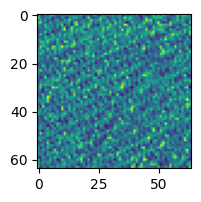

In [9]:
plt.figure(figsize=(2, 2))
plt.imshow(x_train[258,:,:])
print(y_train[258])

## Define model:

In [10]:
def create_simple_cnn_model(input_shape, num_classes):
    model = Sequential()
    model.add(Conv2D(16, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    model.summary()
    return model

In [11]:
input_shape = (64, 64, 1)
num_classes = 2

model = create_simple_cnn_model(input_shape, num_classes)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 16)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 15376)             0         
                                                                 
 dense (Dense)               (None, 32)                492064    
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 2)                 66        
                                                        

In [12]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

## Train

In [13]:
simple_history = model.fit(x_train, y_train_one_hot, epochs=1, batch_size=16, validation_data=(x_test, y_test_one_hot))

90/90 [==============================] - 3s 23ms/step - loss: 0.3395 - accuracy: 0.8417 - val_loss: 0.0661 - val_accuracy: 1.0000


## Evaluation:

In [14]:
test_loss, test_acc = model.evaluate(x_test, y_test_one_hot)
print('Test accuracy:', test_acc)

12/12 [==============================] - 0s 9ms/step - loss: 0.0661 - accuracy: 1.0000
Test accuracy: 1.0


In [15]:
class_labels = ["Slätvävd", 
                "jeans", 
]

12/12 [==============================] - 0s 8ms/step


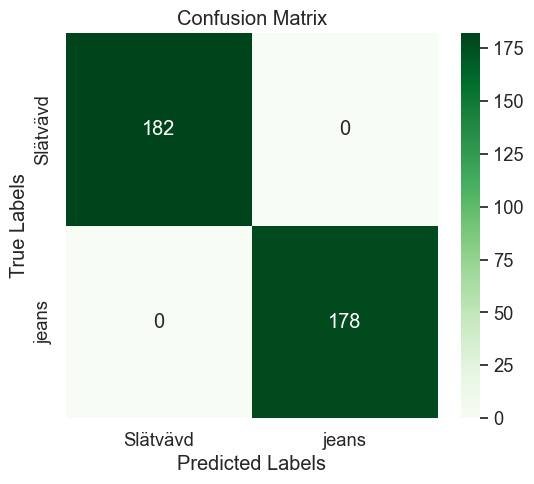

In [16]:
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = y_test
confusion_mat = confusion_matrix(y_true_classes, y_pred_classes)

plt.figure(figsize=(6, 5))
sns.set(font_scale=1.2)  
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap="Greens", 
            xticklabels= class_labels,
            yticklabels= class_labels,)

plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

## Save model:

In [20]:
#model.save("jeans_model_24-03-06.h5")


## Testing:

In [18]:
image_paths = [
"./test_img/test11.jpg",
"./test_img/test12.jpg",
"./test_img/test13.jpg",
"./test_img/test14.jpg",
"./test_img/test7.jpg",
"./test_img/test8.jpg",
"./test_img/test9.jpg",
"./test_img/test10.jpg",
"./test_img/test1.jpg",
"./test_img/test2.jpg",
]

1/1 [==============================] - 0s 26ms/step


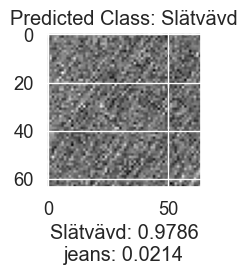

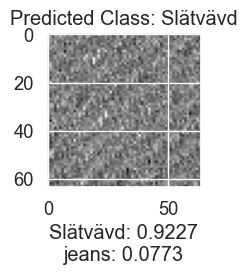

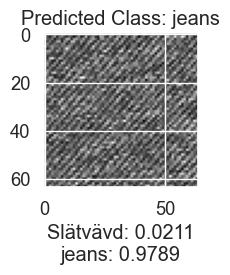

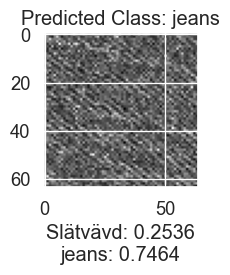

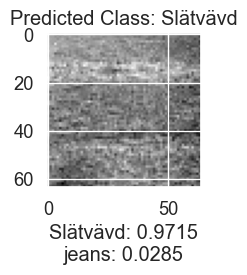

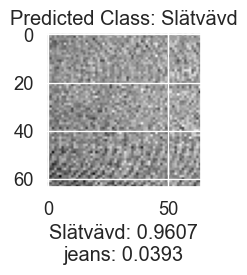

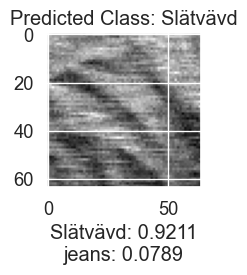

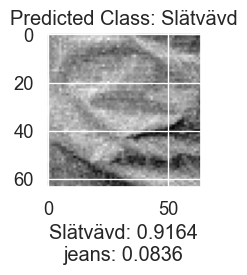

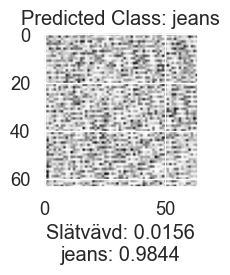

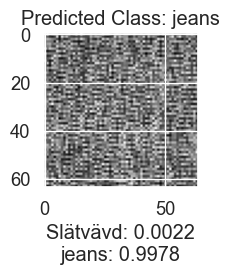

In [19]:
def preprocess_image(image):
    img_preprocessed = cv2.resize(img, img_dim)
    img_preprocessed = np.expand_dims(img_preprocessed, axis=-1) 

    return img_preprocessed

testing_images = []
for image_path in image_paths:
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img_preprocessed = preprocess_image(img)
    testing_images.append(img_preprocessed)

testing_images = np.array(testing_images) / 255.0 

predictions = model.predict(testing_images)

for i in range(len(image_paths)):
    plt.figure(figsize=(2, 2))
    plt.imshow(testing_images[i].reshape(64, 64), cmap='gray')
    predicted_class = np.argmax(predictions[i])
    plt.title(f"Predicted Class: {class_labels[predicted_class]}")
    plt.xlabel("\n".join([f"{class_labels[j]}: {predictions[i][j]:.4f}" for j in range(predictions.shape[1])]))
    plt.show()